# Unsupervised Methods: Topic Modeling and Clustering

## Load Python Settings<div class="tocSkip"/>

Common imports, defaults for formatting in Matplotlib, Pandas etc.

In [1]:
# suppress warnings
import warnings;
warnings.filterwarnings('ignore');

# common imports
import pandas as pd
import numpy as np
import math
import re
import glob
import os
import sys
import json
import random
import pprint as pp
import textwrap
import sqlite3
import logging

import spacy
import nltk

from tqdm.auto import tqdm
# register `pandas.progress_apply` and `pandas.Series.map_apply` with `tqdm`
tqdm.pandas()

# pandas display options
# https://pandas.pydata.org/pandas-docs/stable/user_guide/options.html#available-options
pd.options.display.max_columns = 30 # default 20
pd.options.display.max_rows = 60 # default 60
pd.options.display.float_format = '{:.2f}'.format
# pd.options.display.precision = 2
pd.options.display.max_colwidth = 200 # default 50; -1 = all
# otherwise text between $ signs will be interpreted as formula and printed in italic
pd.set_option('display.html.use_mathjax', False)

# np.set_printoptions(edgeitems=3) # default 3

import matplotlib
from matplotlib import pyplot as plt

plot_params = {'figure.figsize': (8, 4), 
               'axes.labelsize': 'large',
               'axes.titlesize': 'large',
               'xtick.labelsize': 'large',
               'ytick.labelsize':'large',
               'figure.dpi': 100}
# adjust matplotlib defaults
matplotlib.rcParams.update(plot_params)

import seaborn as sns
sns.set_style("darkgrid")

# Load data

In [2]:
import pandas as pd
df = pd.read_csv('un-general-debates.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7507 entries, 0 to 7506
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   session       7507 non-null   int64 
 1   year          7507 non-null   int64 
 2   country       7507 non-null   object
 3   country_name  7507 non-null   object
 4   speaker       7480 non-null   object
 5   position      4502 non-null   object
 6   text          7507 non-null   object
dtypes: int64(2), object(5)
memory usage: 410.7+ KB


In [3]:
print(repr(df.iloc[0]["text"][0:200]))
print(repr(df.iloc[-1]["text"][0:200]))

'33: May I first convey to our President the congratulations of the Albanian delegation on his election to the Presidency of the twenty-fifth session of the General Assembly?\n34.\tIn taking up the work '
'Allow me at the outset to extend to Mr. Mogens Lykketoft my warm congratulations on his election to the high office of President of the General Assembly at its seventieth session. He assumes this offi'


# Split and analyze

In [4]:
import re
df["paragraphs"] = df["text"].map(lambda text: re.split('\.\s*\n', text))
df["number_of_paragraphs"] = df["paragraphs"].map(len)

<AxesSubplot:xlabel='year'>

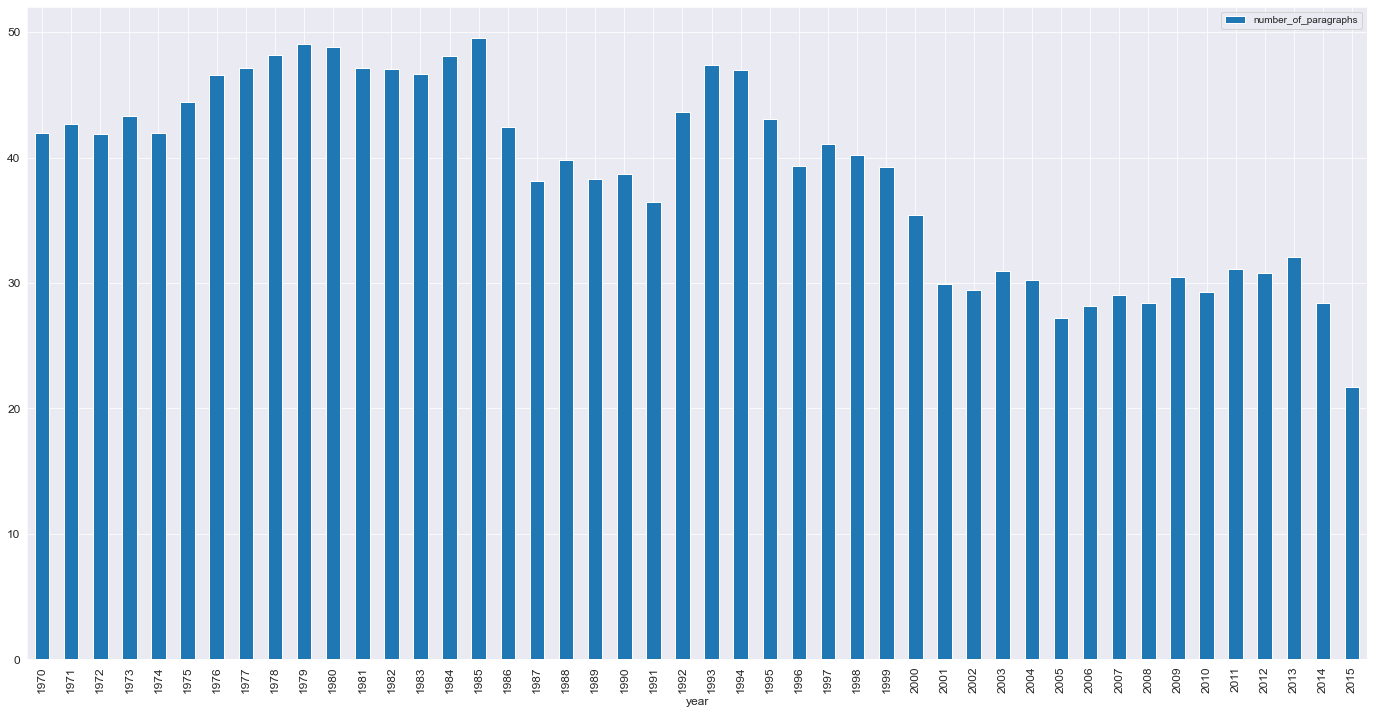

In [5]:
%matplotlib inline
df.groupby('year').agg({'number_of_paragraphs': 'mean'}).plot.bar(figsize=(24,12))

In [6]:
from sklearn.feature_extraction.text import TfidfVectorizer
from spacy.lang.en.stop_words import STOP_WORDS as stopwords

In [7]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(7507, 24611)

In [8]:
# flatten the paragraphs keeping the years
paragraph_df = pd.DataFrame([{ "text": paragraph, "year": year } 
                               for paragraphs, year in zip(df["paragraphs"], df["year"]) 
                                    for paragraph in paragraphs if paragraph])

In [9]:
tfidf_para_vectorizer = TfidfVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
tfidf_para_vectors = tfidf_para_vectorizer.fit_transform(paragraph_df["text"])
tfidf_para_vectors.shape

(279076, 25162)

# NMF

## Speeches

In [10]:
from sklearn.decomposition import NMF

nmf_text_model = NMF(n_components=10, random_state=42)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [11]:
def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

In [12]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names())


Topic 00
  co (0.79)
  operation (0.65)
  disarmament (0.36)
  nuclear (0.34)
  relations (0.25)

Topic 01
  terrorism (0.38)
  challenges (0.32)
  sustainable (0.30)
  millennium (0.29)
  reform (0.28)

Topic 02
  africa (1.15)
  african (0.82)
  south (0.63)
  namibia (0.36)
  delegation (0.30)

Topic 03
  arab (1.02)
  israel (0.89)
  palestinian (0.60)
  lebanon (0.54)
  israeli (0.54)

Topic 04
  american (0.33)
  america (0.31)
  latin (0.31)
  panama (0.21)
  bolivia (0.21)

Topic 05
  pacific (1.55)
  islands (1.23)
  solomon (0.86)
  island (0.82)
  fiji (0.71)

Topic 06
  soviet (0.81)
  republic (0.78)
  nuclear (0.68)
  viet (0.64)
  socialist (0.63)

Topic 07
  guinea (4.26)
  equatorial (1.75)
  bissau (1.53)
  papua (1.47)
  republic (0.57)

Topic 08
  european (0.61)
  europe (0.44)
  cooperation (0.39)
  bosnia (0.34)
  herzegovina (0.30)

Topic 09
  caribbean (0.98)
  small (0.66)
  bahamas (0.63)
  saint (0.63)
  barbados (0.61)


In [13]:
W_text_matrix.sum(axis=0)/W_text_matrix.sum()*100.0

array([11.14353588, 17.10877242, 13.61965772, 10.16345439, 11.41042599,
        5.93353622,  7.86636069,  4.13893748, 11.84152198,  6.77379723])

## Paragraphs

In [14]:
nmf_para_model = NMF(n_components=10, random_state=42)
W_para_matrix = nmf_para_model.fit_transform(tfidf_para_vectors)
H_para_matrix = nmf_para_model.components_

In [15]:
display_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names())


Topic 00
  nations (5.61)
  united (5.49)
  organization (1.27)
  states (1.02)
  charter (0.93)

Topic 01
  general (2.86)
  session (2.83)
  assembly (2.81)
  mr (1.99)
  president (1.81)

Topic 02
  countries (4.41)
  developing (2.49)
  economic (1.50)
  developed (1.35)
  trade (0.92)

Topic 03
  people (1.36)
  peace (1.33)
  east (1.28)
  middle (1.17)
  palestinian (1.15)

Topic 04
  nuclear (4.93)
  weapons (3.26)
  disarmament (2.01)
  treaty (1.70)
  proliferation (1.46)

Topic 05
  rights (6.48)
  human (6.16)
  respect (1.15)
  fundamental (0.85)
  universal (0.82)

Topic 06
  africa (3.81)
  south (3.30)
  african (1.70)
  namibia (1.38)
  apartheid (1.18)

Topic 07
  security (6.10)
  council (5.87)
  permanent (1.49)
  reform (1.49)
  peace (1.30)

Topic 08
  international (2.03)
  world (1.48)
  community (0.91)
  new (0.76)
  peace (0.67)

Topic 09
  development (4.47)
  sustainable (1.19)
  economic (1.06)
  social (0.99)
  goals (0.94)


In [16]:
W_para_matrix.sum(axis=0)/W_para_matrix.sum()*100.0

array([10.61162166, 10.34430821, 10.16803041, 10.04420303,  6.63538336,
        7.35268755,  8.9000421 ,  8.28986812, 16.7126125 , 10.94124304])

# TruncatedSVD

In [17]:
from sklearn.decomposition import TruncatedSVD

svd_para_model = TruncatedSVD(n_components = 10, random_state=42)
W_svd_para_matrix = svd_para_model.fit_transform(tfidf_para_vectors)
H_svd_para_matrix = svd_para_model.components_

In [18]:
display_topics(svd_para_model, tfidf_para_vectorizer.get_feature_names())


Topic 00
  nations (0.67)
  united (0.65)
  international (0.58)
  peace (0.46)
  world (0.46)

Topic 01
  general (14.25)
  assembly (13.32)
  session (13.19)
  mr (10.22)
  president (8.76)

Topic 02
  countries (20.95)
  development (16.12)
  economic (15.29)
  developing (14.28)
  session (11.14)

Topic 03
  nations (4.43)
  united (4.07)
  development (0.93)
  organization (0.85)
  charter (0.81)

Topic 04
  nuclear (20.20)
  weapons (13.39)
  disarmament (8.64)
  treaty (6.93)
  proliferation (6.06)

Topic 05
  rights (28.41)
  human (27.71)
  nuclear (8.64)
  weapons (6.05)
  respect (4.81)

Topic 06
  africa (9.02)
  south (8.42)
  united (3.91)
  african (3.89)
  namibia (3.56)

Topic 07
  council (14.36)
  security (13.05)
  africa (7.88)
  south (5.65)
  reform (3.77)

Topic 08
  world (39.38)
  peace (29.97)
  international (28.78)
  africa (18.09)
  new (16.47)

Topic 09
  development (59.33)
  sustainable (19.32)
  peace (16.94)
  goals (14.87)
  africa (12.88)


In [19]:
svd_para_model.singular_values_

array([71.58542396, 39.32344616, 36.48183715, 34.81530053, 33.26015445,
       31.44496673, 29.85898267, 28.66414412, 26.99316039, 26.7319264 ])

# LDA

In [20]:
from sklearn.feature_extraction.text import CountVectorizer
count_para_vectorizer = CountVectorizer(stop_words=stopwords, min_df=5, max_df=0.7)
count_para_vectors = count_para_vectorizer.fit_transform(paragraph_df["text"])
count_para_vectors.shape

(279076, 25162)

In [21]:
from sklearn.decomposition import LatentDirichletAllocation

lda_para_model = LatentDirichletAllocation(n_components = 10, random_state=42)
W_lda_para_matrix = lda_para_model.fit_transform(count_para_vectors)
H_lda_para_matrix = lda_para_model.components_

In [22]:
display_topics(lda_para_model, count_para_vectorizer.get_feature_names())


Topic 00
  general (4.46)
  assembly (3.55)
  session (3.09)
  president (2.12)
  mr (1.91)

Topic 01
  world (2.60)
  human (1.17)
  people (0.92)
  peace (0.80)
  nations (0.72)

Topic 02
  nuclear (2.88)
  weapons (2.13)
  disarmament (1.67)
  arms (1.39)
  states (1.23)

Topic 03
  international (2.36)
  security (2.18)
  united (2.02)
  nations (2.01)
  council (1.95)

Topic 04
  countries (4.60)
  economic (2.86)
  developing (2.01)
  development (1.51)
  international (1.46)

Topic 05
  peace (2.13)
  east (1.43)
  middle (1.34)
  people (1.31)
  israel (1.24)

Topic 06
  states (1.77)
  countries (1.45)
  peace (1.23)
  relations (1.22)
  peoples (1.19)

Topic 07
  africa (3.06)
  south (2.04)
  united (1.83)
  nations (1.58)
  african (1.04)

Topic 08
  people (1.80)
  republic (1.50)
  government (1.41)
  united (1.26)
  nations (1.04)

Topic 09
  nations (3.25)
  united (2.91)
  development (2.33)
  international (1.69)
  world (1.13)


In [23]:
W_lda_para_matrix.sum(axis=0)/W_lda_para_matrix.sum()*100.0

array([ 8.96413708, 13.1939403 ,  7.04455321, 11.08311812,  9.84055263,
        8.80334442,  8.89408336,  6.94897733,  9.48290182, 15.74439172])

In [25]:
import pyLDAvis.sklearn

lda_display = pyLDAvis.sklearn.prepare(lda_para_model, count_para_vectors, count_para_vectorizer, sort_topics=False)
pyLDAvis.display(lda_display)

In [26]:
lda_tsne_display = pyLDAvis.sklearn.prepare(lda_para_model, count_para_vectors, count_para_vectorizer, sort_topics=False, mds='tsne')
pyLDAvis.display(lda_tsne_display)

/Users/luetgert/anaconda3/envs/textanalysis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/luetgert/anaconda3/envs/textanalysis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/luetgert/anaconda3/envs/textanalysis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/luetgert/anaconda3/envs/textanalysis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


# Display Topic Models and Compare as Wordclouds

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from wordcloud import WordCloud

def wordcloud_topics(model, features, no_top_words=40):
    for topic, words in enumerate(model.components_):
        size = {}
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

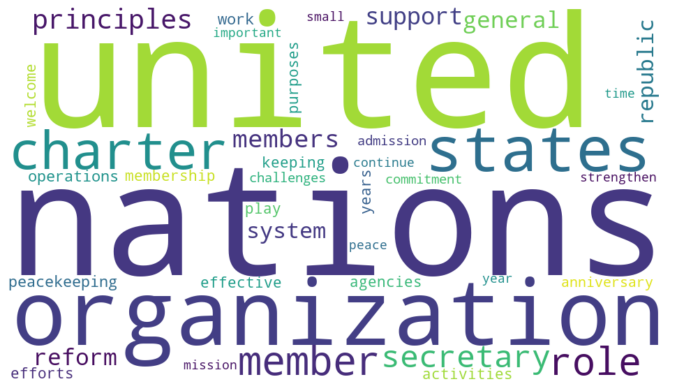

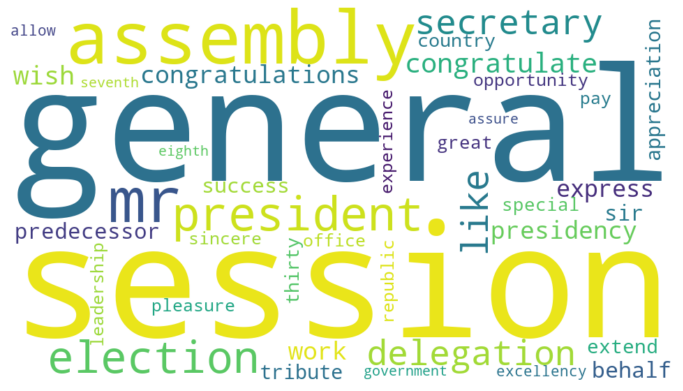

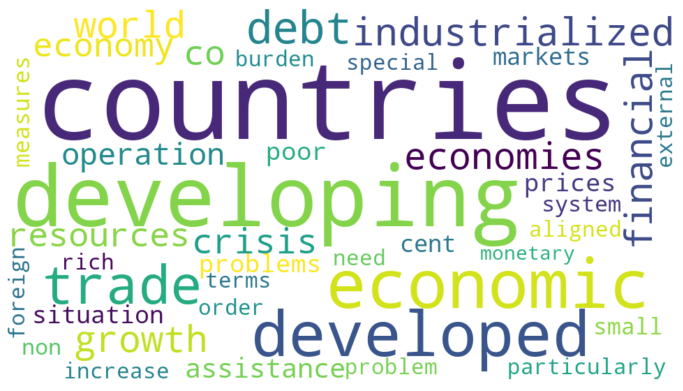

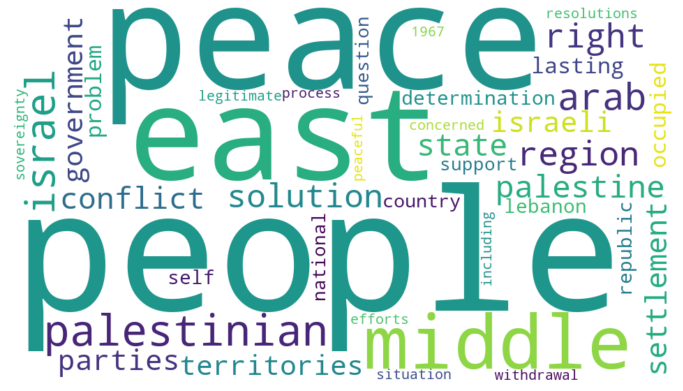

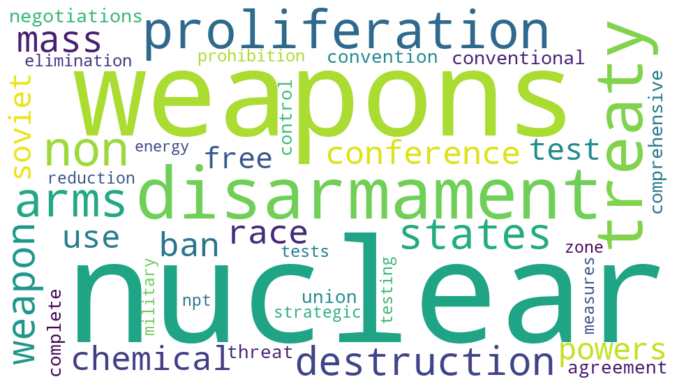

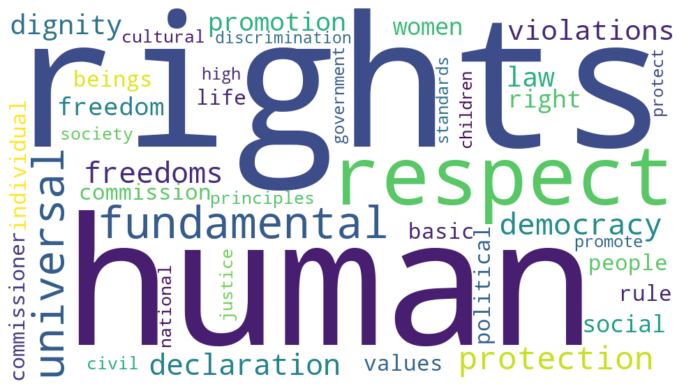

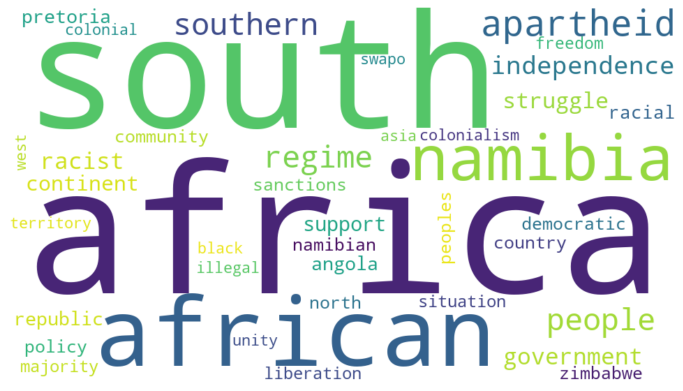

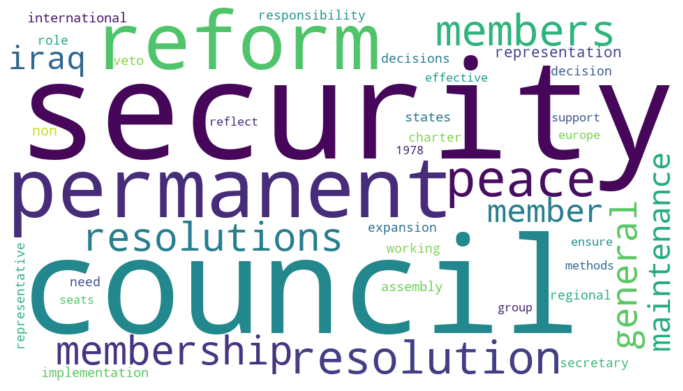

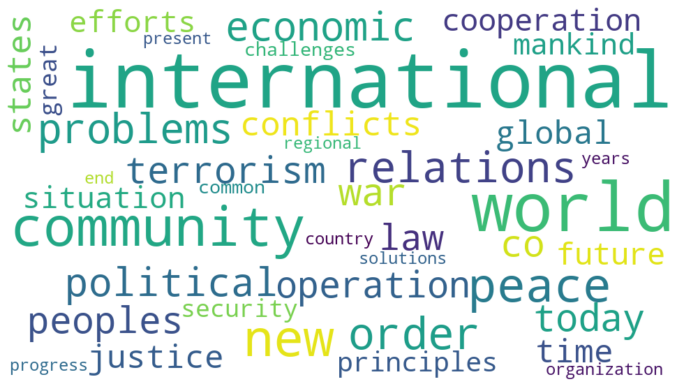

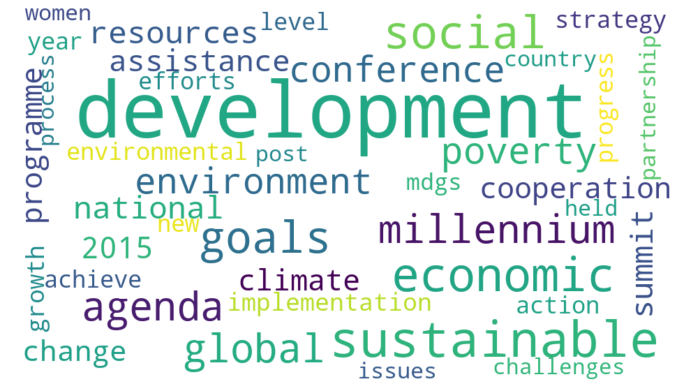

In [28]:
wordcloud_topics(nmf_para_model, tfidf_para_vectorizer.get_feature_names())

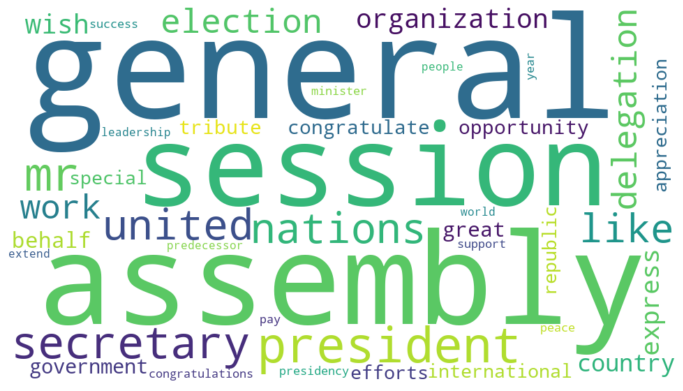

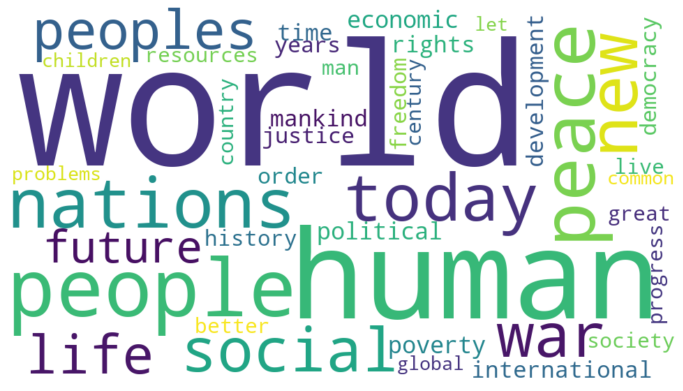

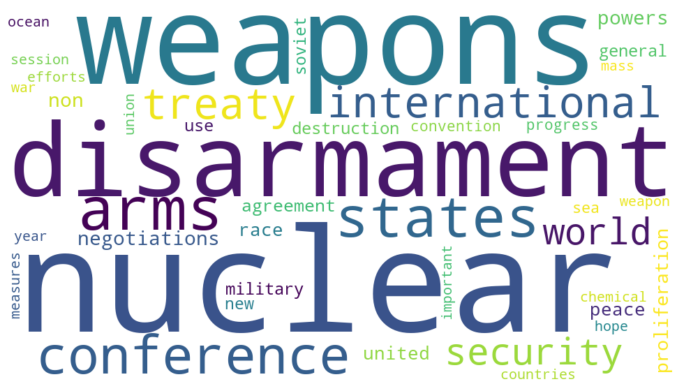

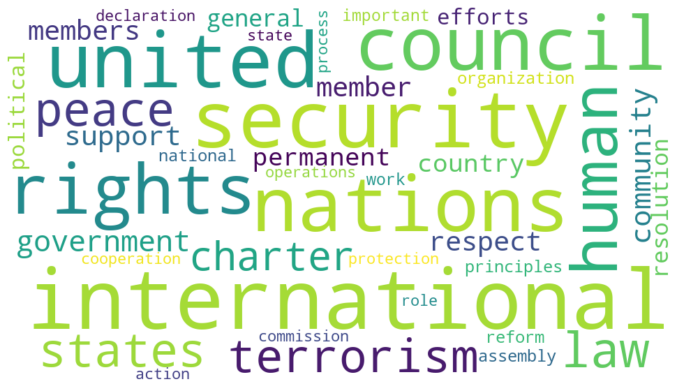

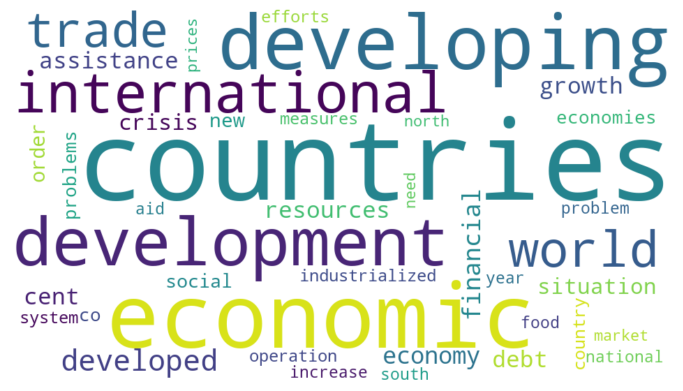

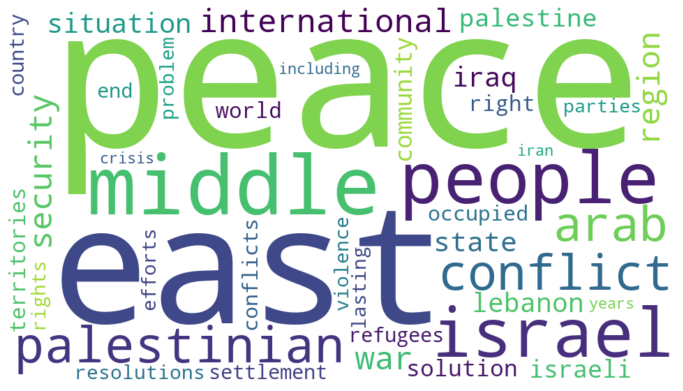

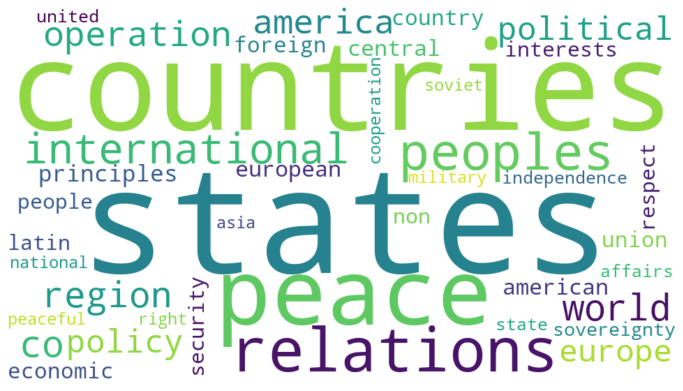

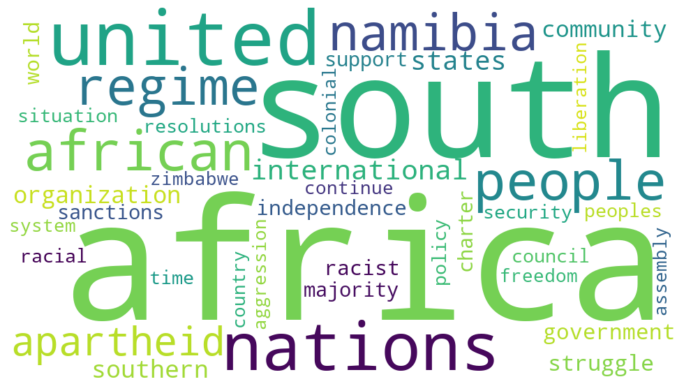

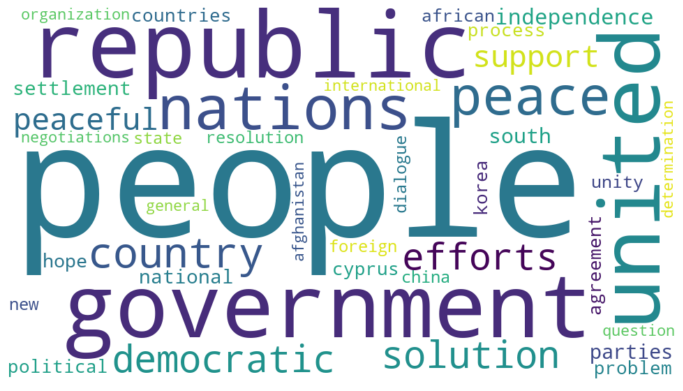

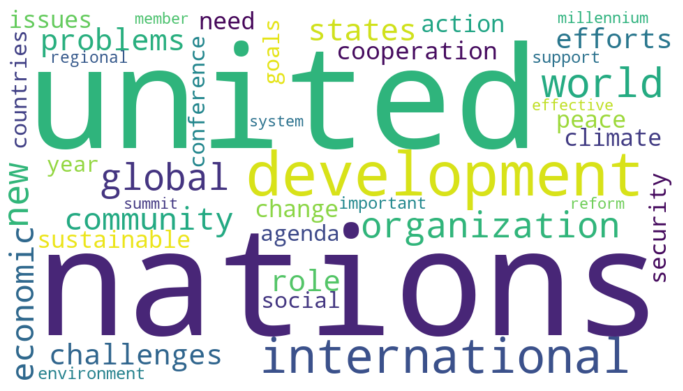

In [29]:
wordcloud_topics(lda_para_model, count_para_vectorizer.get_feature_names())

# Time Development of Topic Models

In [30]:
W_para_matrix.sum(axis=0)/W_para_matrix.sum()*100.0

array([10.61162166, 10.34430821, 10.16803041, 10.04420303,  6.63538336,
        7.35268755,  8.9000421 ,  8.28986812, 16.7126125 , 10.94124304])

/Users/luetgert/anaconda3/envs/textanalysis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/luetgert/anaconda3/envs/textanalysis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/luetgert/anaconda3/envs/textanalysis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload
/Users/luetgert/anaconda3/envs/textanalysis/lib/python3.8/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [31]:
import numpy as np
before_1990 = np.array(paragraph_df["year"] < 1990)
after_1990 = ~ before_1990

In [32]:
W_para_matrix_early = nmf_para_model.transform(tfidf_para_vectors[before_1990])
W_para_matrix_late  = nmf_para_model.transform(tfidf_para_vectors[after_1990])
print(W_para_matrix_early.sum(axis=0)/W_para_matrix_early.sum()*100.0)
print(W_para_matrix_late.sum(axis=0)/W_para_matrix_late.sum()*100.0)

[ 9.37137207 10.47481124 12.21034735 12.05446286  7.83086449  6.06448404
 12.1987452   5.86103225 17.27279106  6.66108945]
[11.60143262 10.23994837  8.53792591  8.44156154  5.68128207  8.38095034
  6.26619475 10.22876593 16.26459031 14.35734816]


In [33]:
['%1.2f'%x for x in W_para_matrix_early.sum(axis=0)/W_para_matrix_early.sum()*100.0]

['9.37',
 '10.47',
 '12.21',
 '12.05',
 '7.83',
 '6.06',
 '12.20',
 '5.86',
 '17.27',
 '6.66']

In [34]:
['%1.2f'%x for x in W_para_matrix_early.sum(axis=0)/W_para_matrix_late.sum()*100.0]

['7.48',
 '8.36',
 '9.75',
 '9.62',
 '6.25',
 '4.84',
 '9.74',
 '4.68',
 '13.79',
 '5.32']

In [35]:
from tqdm.auto import tqdm
import numpy as np
year_data = []
for year in tqdm(np.unique(np.unique(paragraph_df["year"]))):
    W_year = nmf_para_model.transform(tfidf_para_vectors[np.array(paragraph_df["year"] == year)])
    year_data.append([year] + list(W_year.sum(axis=0)/W_year.sum()*100.0))

  0%|          | 0/46 [00:00<?, ?it/s]

In [36]:
topic_names = []
voc = tfidf_para_vectorizer.get_feature_names()
for topic in nmf_para_model.components_:
    important = topic.argsort()
    top_word = voc[important[-1]] + " " + voc[important[-2]]
    topic_names.append("Topic " + top_word)

In [37]:
import matplotlib.pyplot as plt

<AxesSubplot:xlabel='year'>

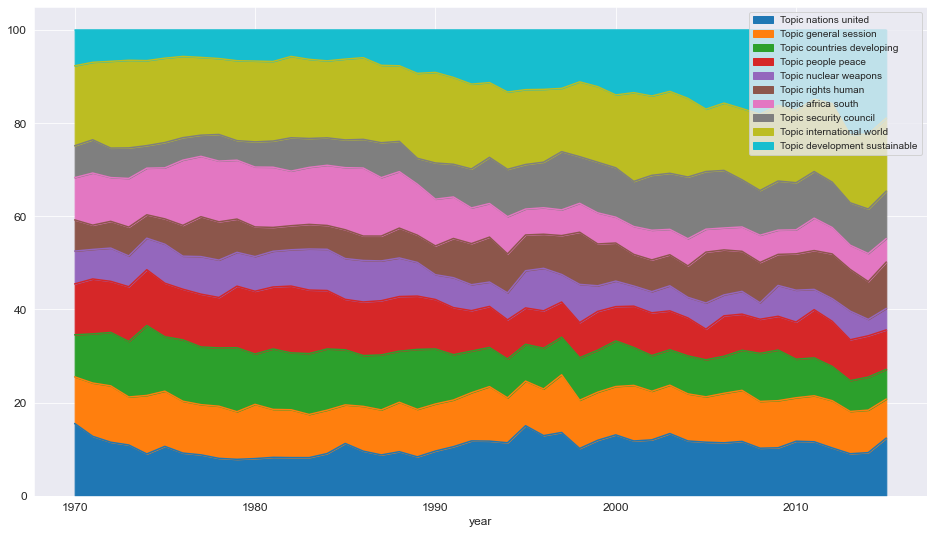

In [41]:
df_year = pd.DataFrame(year_data, columns=["year"] + topic_names).set_index("year")
df_year.plot.area(figsize=(16,9))

In [42]:
[f'Topic {count_para_vectorizer.get_feature_names()[words.argsort()[-1]]}' for words in nmf_para_model.components_]

['Topic nations',
 'Topic general',
 'Topic countries',
 'Topic people',
 'Topic nuclear',
 'Topic rights',
 'Topic africa',
 'Topic security',
 'Topic international',
 'Topic development']

<AxesSubplot:xlabel='year'>

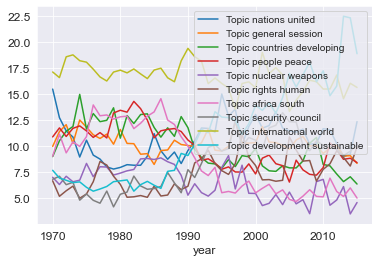

In [43]:
df_year.plot()

# Optimal number of topics

In [44]:
lda_para_model.perplexity(tfidf_para_vectors)

10202.574489607177

In [ ]:
from tqdm.auto import tqdm
lda_para_model_n = []
for n in tqdm(range(5, 21)):
    lda_model = LatentDirichletAllocation(n_components = n, random_state=42)
    lda_model.fit_transform(count_para_vectors)
    lda_perplexity = lda_model.perplexity(tfidf_para_vectors)
    lda_para_model_n.append((lda_model, lda_perplexity))

  0%|          | 0/16 [00:00<?, ?it/s]

In [ ]:
lda_para_model_n

# Gensim

In [ ]:
# create tokenized documents
gensim_paragraphs = [[w for w in re.findall(r'\b\w\w+\b' , paragraph.lower()) if w not in stopwords] 
                           for paragraph in paragraph_df["text"]]

In [ ]:
from gensim.corpora import Dictionary

dict_gensim_para = Dictionary(gensim_paragraphs) 

In [ ]:
dict_gensim_para.filter_extremes(no_below=5, no_above=0.7)

In [ ]:
bow_gensim_para = [dict_gensim_para.doc2bow(paragraph) for paragraph in gensim_paragraphs]

In [ ]:
from gensim.models import TfidfModel
tfidf_gensim_para = TfidfModel(bow_gensim_para)
vectors_gensim_para = tfidf_gensim_para[bow_gensim_para]

## NMF

In [ ]:
from gensim.models.nmf import Nmf

nmf_gensim_para = Nmf(vectors_gensim_para, num_topics=10, id2word=dict_gensim_para, kappa=0.1, eval_every=5, random_state=42) 

In [ ]:
def display_topics_gensim(model):
    for topic in range(0, model.num_topics):
        print("\nTopic %02d" % topic)
        for (word, prob) in model.show_topic(topic, topn=5):
            print("  %s (%2.2f)" % (word, prob))

In [ ]:
display_topics_gensim(nmf_gensim_para)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

nmf_gensim_para_coherence = CoherenceModel(model=nmf_gensim_para, texts=gensim_paragraphs, dictionary=dict_gensim_para, coherence='c_v')
nmf_gensim_para_coherence_score = nmf_gensim_para_coherence.get_coherence()
print(nmf_gensim_para_coherence_score)

## LDA

In [ ]:
from gensim.models import LdaModel
lda_gensim_para = LdaModel(corpus=bow_gensim_para, id2word=dict_gensim_para, chunksize=2000,
    alpha='auto', eta='auto', iterations=400, num_topics=10, passes=20, eval_every=None, random_state=42)

In [ ]:
display_topics_gensim(lda_gensim_para)

In [ ]:
lda_gensim_para.log_perplexity(vectors_gensim_para)

In [ ]:
from gensim.models.coherencemodel import CoherenceModel

lda_gensim_para_coherence = CoherenceModel(model=lda_gensim_para, texts=gensim_paragraphs, dictionary=dict_gensim_para, coherence='c_v')
lda_gensim_para_coherence_score = lda_gensim_para_coherence.get_coherence()
print(lda_gensim_para_coherence_score)

In [ ]:
print(lda_gensim_para_coherence_score)

In [ ]:
lda_gensim_para.alpha

In [ ]:
nmf_gensim_para_coherence = CoherenceModel(model=nmf_gensim_para, texts=gensim_paragraphs, dictionary=dict_gensim_para, coherence='c_v')
nmf_gensim_para_coherence_score = nmf_gensim_para_coherence.get_coherence()
print(nmf_gensim_para_coherence_score)

In [ ]:
top_topics = lda_gensim_para.top_topics(vectors_gensim_para, topn=5)
avg_topic_coherence = sum([t[1] for t in top_topics]) / len(top_topics)
print('Average topic coherence: %.4f.' % avg_topic_coherence)

In [ ]:
[(t[1], " ".join([w[1] for w in t[0]])) for t in top_topics]

## Optimize number of LDA topics

In [ ]:
from gensim.models.ldamulticore import LdaMulticore
lda_para_model_n = []
for n in tqdm(range(5, 21)):
    lda_model = LdaMulticore(corpus=bow_gensim_para, id2word=dict_gensim_para, chunksize=2000,
                             eta='auto', iterations=400, num_topics=n, passes=20, 
                             eval_every=None, random_state=42)
    lda_coherence = CoherenceModel(model=lda_model, texts=gensim_paragraphs, 
                                   dictionary=dict_gensim_para, coherence='c_v')
    lda_para_model_n.append((n, lda_model, lda_coherence.get_coherence()))

In [ ]:
pd.DataFrame(lda_para_model_n, columns=["n", "model", "coherence"]).set_index("n")[["coherence"]].plot(figsize=(16,9))

In [ ]:
display_topics_gensim(lda_para_model_n[12][1])

In [ ]:
def wordcloud_topics_gensim(model, no_top_words=40):
    for topic in range(0, model.num_topics):
        size = {}
        for (word, prob) in model.show_topic(topic, topn=no_top_words):
            size[word] = prob
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'topic{topic}.png')

In [ ]:
wordcloud_topics_gensim(lda_para_model_n[12][1])

## HDP

In [ ]:
from gensim.models import HdpModel
hdp_gensim_para = HdpModel(corpus=bow_gensim_para, id2word=dict_gensim_para)

In [ ]:
import re

In [ ]:
words = 8
pd.DataFrame([re.split(r" \+ |\*", t[1]) for t in hdp_gensim_para.print_topics(num_topics=20, num_words=words)])

In [ ]:
pd.set_option('max_colwidth', 1000)
pd.DataFrame(hdp_gensim_para.print_topics(num_topics=40, num_words=10), columns=["topic", "words"]).set_index("topic")

In [ ]:
hdp_gensim_para.show_topic(0, topn=10)

In [ ]:
def display_topics_gensim_hdp(model, num_topics):
    for topic in range(0, num_topics):
        print("\nTopic %02d" % topic)
        for (word, prob) in model.show_topic(topic, topn=10):
            print("  %s (%2.2f)" % (word, prob))

In [ ]:
display_topics_gensim_hdp(hdp_gensim_para, 50)

# Clustering

In [ ]:
from sklearn.cluster import KMeans
k_means_para = KMeans(n_clusters=10, random_state=42)
k_means_para.fit(tfidf_para_vectors)

In [ ]:
sizes = []
for i in range(10):
    sizes.append({"cluster": i, "size": np.sum(k_means_para.labels_==i)})
pd.DataFrame(sizes).set_index("cluster").plot.bar(figsize=(16,9))
fig.savefig("cluster-size.svg")

In [ ]:
np.unique(k_means_para.labels_, return_counts=True)

In [ ]:
def wordcloud_clusters(model, vectors, features, no_top_words=40):
    for cluster in np.unique(model.labels_):
        size = {}
        words = vectors[model.labels_ == cluster].sum(axis=0).A[0]
        largest = words.argsort()[::-1] # invert sort order
        for i in range(0, no_top_words):
            size[features[largest[i]]] = abs(words[largest[i]])
        wc = WordCloud(background_color="white", max_words=100, width=960, height=540)
        wc.generate_from_frequencies(size)
        plt.figure(figsize=(12,12))
        plt.imshow(wc, interpolation='bilinear')
        plt.axis("off")
        # if you don't want to save the topic model, comment the next line
        plt.savefig(f'cluster{cluster}.png')

In [ ]:
wordcloud_clusters(k_means_para, tfidf_para_vectors, tfidf_para_vectorizer.get_feature_names())